# EEG analysis

In [32]:
%matplotlib qt

import mne
import matplotlib.pyplot as plt
import numpy as np

## Edf files

In [33]:
from utils import create_montage
path = "subjects/S001/S001R05.edf"
raw = mne.io.read_raw_edf(path, preload=True)
create_montage(raw)

Extracting EDF parameters from c:\Users\yassi\OneDrive\Documents\AI\MNE\subjects\S001\S001R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


## Filter and referencing

In [34]:
raw.filter(1., 40., fir_design='firwin')

# Re-référencer à la moyenne des canaux EEG
raw.set_eeg_reference('average')

# Identifier canaux mauvais manuellement ou automatiquement
raw.info['bads'] = ['FC1', 'TP8']  # exemple

# Interpoler canaux mauvais
raw.interpolate_bads()

# ICA suppression artefacts (ex. clignements)
from mne.preprocessing import ICA

ica = ICA(n_components=20, random_state=97)
ica.fit(raw)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


    Automatic origin fit: head of radius 98.4 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 0.5s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,40 iterations on raw data (20000 samples)
ICA components,20
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


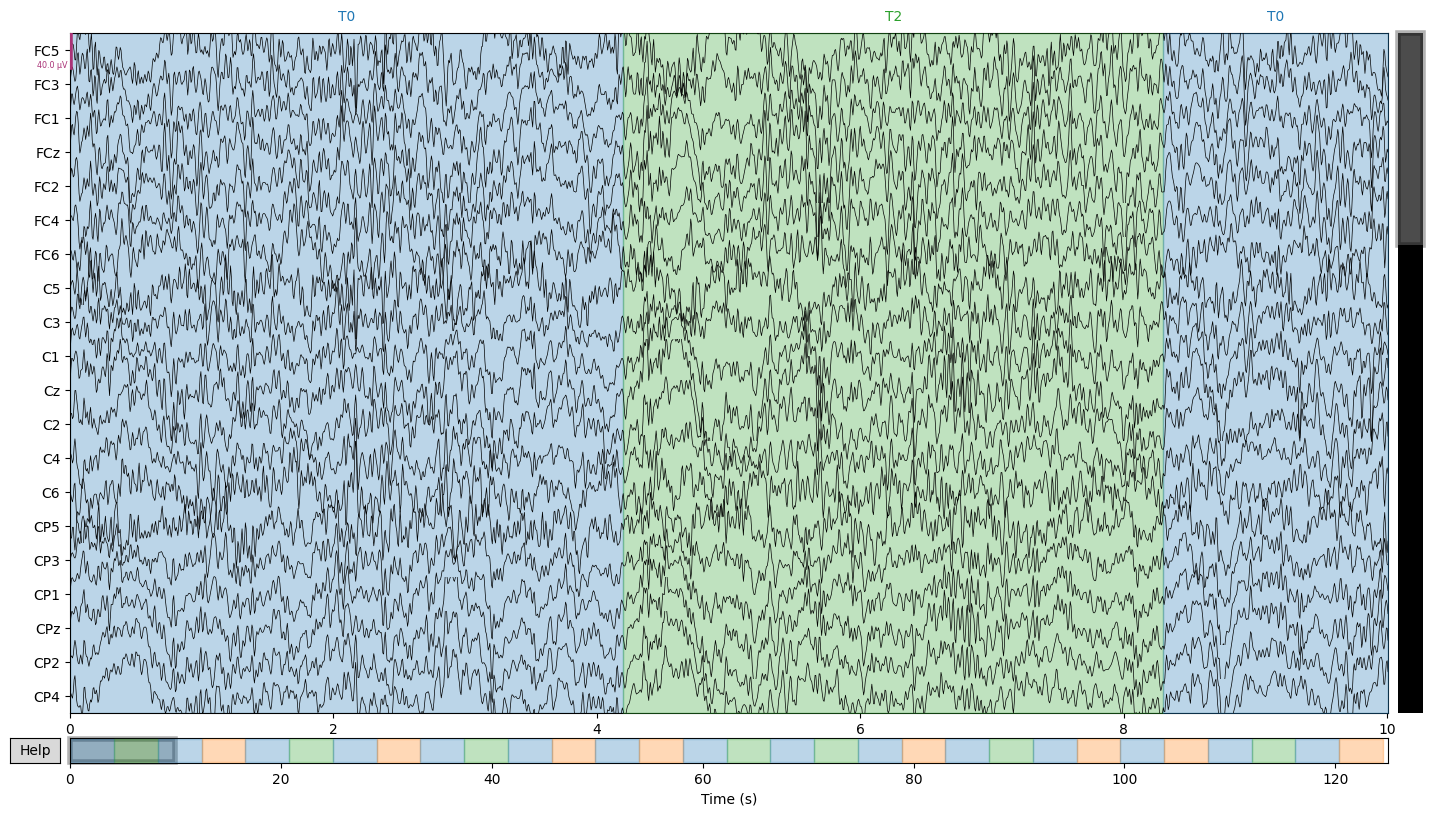

In [35]:
raw.plot()

## Epoch segmentation

In [36]:
import pandas as pd

events, event_id = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw, events, event_id=event_id,
                    tmin=-0.2, tmax=0.8, preload=True)

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
30 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 161 original time points ...
1 bad epochs dropped


In [37]:
channel_means = {}
for condition in event_id:
    data = epochs[condition].get_data()
    mean = data.mean(axis=2).mean(axis=0)
    channel_means[condition] = mean

## Epoch vizualisation

In [38]:
import matplotlib.pyplot as plt
from mne.viz import plot_topomap

# Extract info from raw
info = raw.info

for cond, mean_values in channel_means.items():
    fig, ax = plt.subplots()
    plot_topomap(mean_values, info, axes=ax, show=False)
    ax.set_title(f'Mean amplitude - {cond}')
plt.show()

## Statistical comparison between conditions

In [39]:
from mne.stats import permutation_cluster_test

# Extract data arrays for two conditions (n_epochs, n_channels, n_times)
data_cond1 = epochs['T0'].get_data()
data_cond2 = epochs['T1'].get_data()
data_cond3 = epochs['T2'].get_data()

# Average across time window or use data as is (select time range if needed)
data1 = data_cond1.mean(axis=2)  # shape (n_epochs, n_channels)
data2 = data_cond2.mean(axis=2)
data3 = data_cond3.mean(axis=2)

T_obs, clusters, cluster_pv, H0 = permutation_cluster_test([data1, data2, data3], n_permutations=1000)


Using a threshold of 3.369016


stat_fun(H1): min=0.04520589545394682 max=9.966008702439167
Running initial clustering …
Found 7 clusters


C:\Users\yassi\AppData\Local\Temp\ipykernel_18320\722561367.py:13: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_pv, H0 = permutation_cluster_test([data1, data2, data3], n_permutations=1000)
100%|██████████| Permuting : 999/999 [00:00<00:00, 4408.33it/s]


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.5s finished


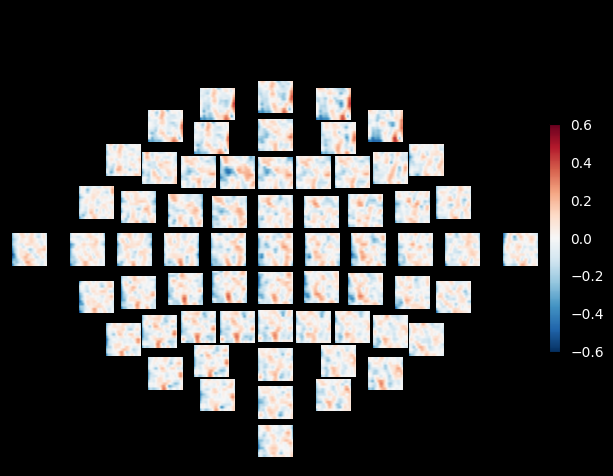

Channels marked as bad:
none


In [40]:
freqs = np.arange(5, 30, 2)  # 6 to 28 Hz
n_cycles = freqs / 2.

power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False)
power.plot_topo(baseline=(-0.2, 2), mode='logratio')

## Step 6: Artifact rejection and data cleaning



In [48]:
reject_criteria = dict(eeg=300e-6)
print(epochs)
epochs_clean = epochs.copy().drop_bad(reject=reject_criteria)

ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter='auto')
ica.fit(epochs_clean)

# Find components correlated with EOG channels
eog_indices, eog_scores = ica.find_bads_eog(epochs_clean, ch_name="Fp1")
ica.exclude = eog_indices

epochs_ica = ica.apply(epochs_clean.copy())



<Epochs | 29 events (all good), -0.2 – 0.8 s (baseline -0.2 – 0 s), ~2.4 MiB, data loaded,
 np.str_('T0'): 14
 np.str_('T1'): 8
 np.str_('T2'): 7>
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF8']
    Reje

C:\Users\yassi\AppData\Local\Temp\ipykernel_18320\3072239610.py:6: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs_clean)
C:\Users\yassi\AppData\Local\Temp\ipykernel_18320\3072239610.py:12: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  epochs_ica = ica.apply(epochs_clean.copy())


Creating RawArray with float64 data, n_channels=20, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


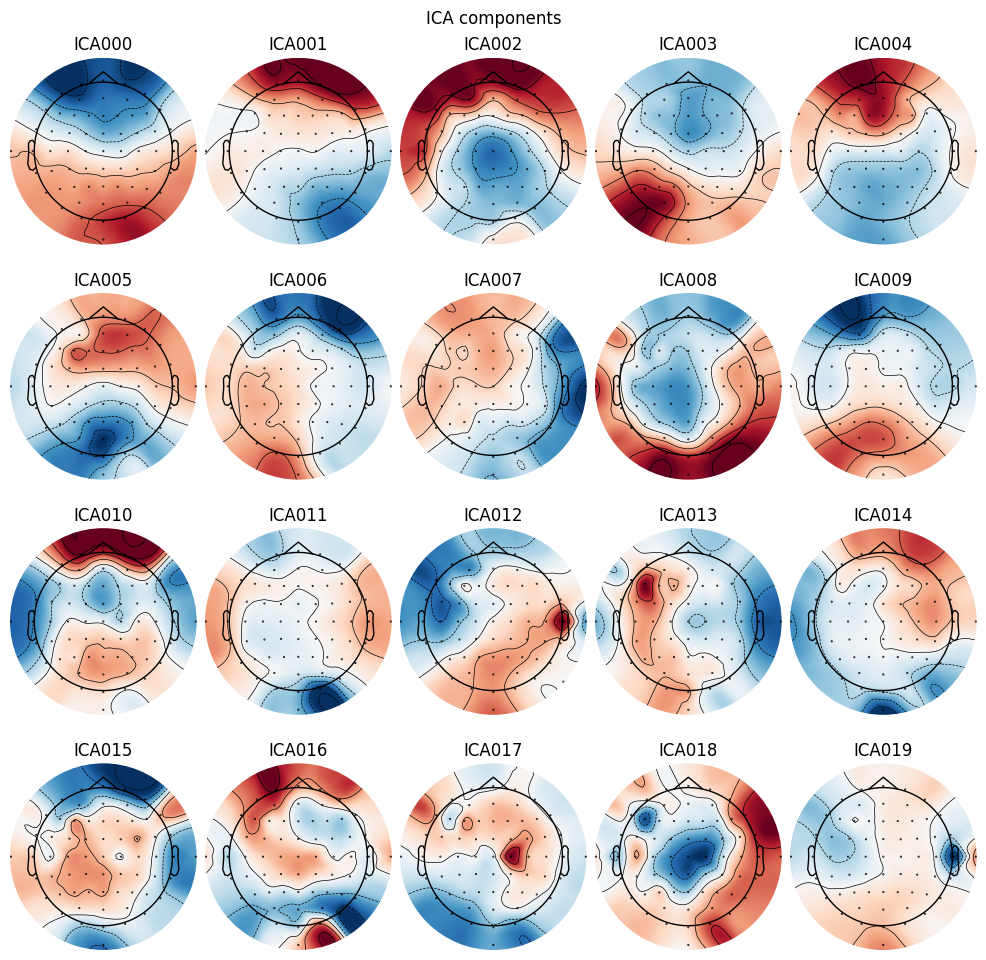

In [53]:
ica.plot_sources(raw) 
ica.apply(raw)                
ica.plot_components()  

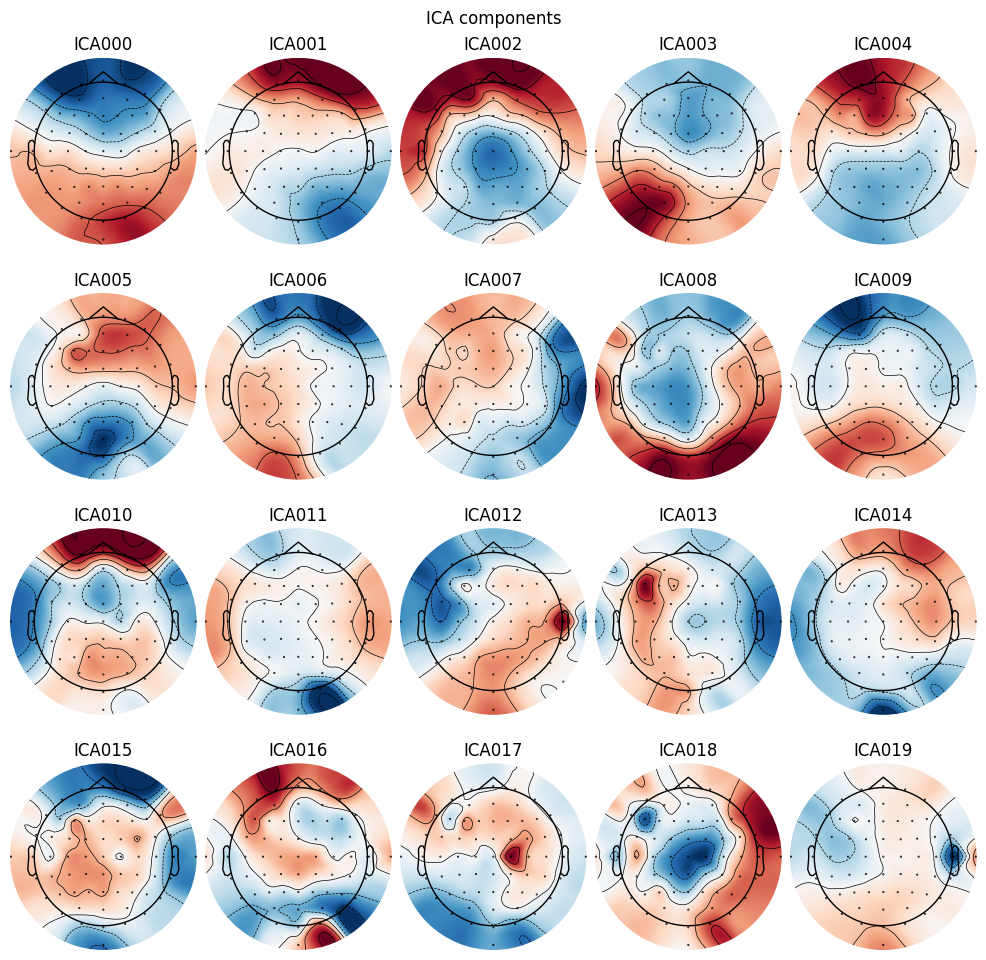